# Smith Creek Water Level

Use full datalog available at https://docs.google.com/spreadsheets/d/1THImtlWGJqnXo7BfNR9S3TnL1TidwLVEFXZrE_Tv6H0/edit?usp=sharing. Save as .csv then open in text editor (VS code). Remove quotation marks by finding and replacing with nothing.

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter

import datetime
import os

from scipy.signal import find_peaks

In [6]:
os.getcwd()

'/Users/bresnahanp'

In [2]:
filepath = os.path.join('Data', 'Water Level 2024 - Sheet1 - 20241218.csv')
df_full = pd.read_csv(filepath, header = None, parse_dates = [1])
df_full.columns = ['Device_ID', 'Datetime Transmission', 'Sensor', 'Event', 'Unix Time', 'Distance (cm)', 'Battery (V)', 'Charge (%)']
df_full.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Data/Water Level 2024 - Sheet1 - 20241218.csv'

In [ ]:
# df_full?

In [ ]:
# Size before truncating
len(df_full)

## Interpret Unix time and get rid of junk dates (i.e., before cell connection)

In [ ]:
# Filter out bad dates (currently using 1708538411 or 2/21/2024 13:00 ET)
df_full = df_full[df_full['Unix Time']>1708538411]

# to round off to nearest second
time_utc = pd.to_datetime(df_full.loc[:, 'Unix Time']*1000000000)
df_full.loc[:, 'Time (ET)'] = time_utc.dt.tz_localize('utc').dt.tz_convert('US/Eastern')
df_full['Water Level (cm)'] = np.zeros(len(df_full))

df_full.head()

In [ ]:
# Size after truncating
len(df_full)

## Separate Sensors
Google Sheet contains data from all sensors in the waterLevel product that publish with eventName beginning with waterLevel. Separate data from the two sensors. 

In [ ]:
# Filter out values noting that sensor id changed
filt_wl_n23 = np.where((df_full['Sensor']=='waterLevel_0000') | (df_full['Sensor']=='waterLevel_0002'))
df_n23 = df_full.iloc[filt_wl_n23]

filt_wl_kerr = np.where((df_full['Sensor']=='waterLevel_0001') | (df_full['Sensor']=='waterLevel_0003'))
df_kerr = df_full.iloc[filt_wl_kerr]

In [ ]:
fig, axs = plt.subplots(figsize = (10, 8))
axs.plot(df_n23['Time (ET)'], df_n23['Distance (cm)'], 'b.-', label = 'N 23rd St.')
axs.plot(df_kerr['Time (ET)'], df_kerr['Distance (cm)'], 'r.-', label = 'Kerr Ave.')

axs.set_ylabel('Distance (cm)')
axs.legend()

# xtick dates are poorly spaced
axs.xaxis.set_major_locator(ticker.MultipleLocator(3.5))

date_form = DateFormatter("%m/%d")
axs.xaxis.set_major_formatter(date_form)

fig.autofmt_xdate()

## Convert distance to water level
Using some known reference point, *a*, convert the distance from sensor to water surface to a water level.  
$H = a-x$  
where *H* is water level, *a* is reference height, and *x* is distance measured by ultrasonic distance sensor. All three should use same units. *a* and *x* are specific to their deployment locations.

From 21-Feb-2024 through 4-Apr-2024, reference values were:

$a_{N23rd,MLLW} =  430.7\ cm\ MLLW$  
$a_{Kerr,MLLW} =  269.1\ cm\ MLLW$  

or 

$a_{N23rd,NAVD88} =  351.5\ cm\ NAVD88$  
$a_{Kerr,NAVD88} =  189.9\ cm\ NAVD88$

After 5-Apr-2024, new designs were deployed and new measurements were collected. New reference values are
$a_{N23rd,NAVD88} =  341.2\ cm\ NAVD88$  
$a_{Kerr,NAVD88} =  182.7\ cm\ NAVD88$

In [ ]:
a_n23_1stDeployment = 351.5 # cm
a_kerr_1stDeployment = 189.9 # cm

a_n23_2ndDeployment = 341.2 # cm
a_kerr_2ndDeployment = 187.2 # cm

filt_wl_n23_1stDeployment = np.where(df_n23['Unix Time']<1712347219)
filt_wl_n23_2ndDeployment = np.where(df_n23['Unix Time']>=1712347219)
df_n23['Water Level (cm)'].iloc[filt_wl_n23_1stDeployment] = a_n23_1stDeployment-df_n23['Distance (cm)'].iloc[filt_wl_n23_1stDeployment]
df_n23['Water Level (cm)'].iloc[filt_wl_n23_2ndDeployment] = a_n23_2ndDeployment-df_n23['Distance (cm)'].iloc[filt_wl_n23_2ndDeployment]

filt_wl_kerr_1stDeployment = np.where(df_kerr['Unix Time']<1712347219)
filt_wl_kerr_2ndDeployment = np.where(df_kerr['Unix Time']>=1712347219)
df_kerr['Water Level (cm)'].iloc[filt_wl_kerr_1stDeployment] = a_kerr_1stDeployment-df_kerr['Distance (cm)'].iloc[filt_wl_kerr_1stDeployment]
df_kerr['Water Level (cm)'].iloc[filt_wl_kerr_2ndDeployment] = a_kerr_2ndDeployment-df_kerr['Distance (cm)'].iloc[filt_wl_kerr_2ndDeployment]

In [ ]:
fig, axs = plt.subplots(figsize = (10, 8))
axs.plot(df_n23['Time (ET)'], df_n23['Water Level (cm)'], 'b.-', label = 'N 23rd St.')
axs.plot(df_kerr['Time (ET)'], df_kerr['Water Level (cm)'], 'r.-', label = 'Kerr Ave.')

axs.set_ylabel('Water Level (cm, NAVD)')
axs.legend()

# xtick dates are poorly spaced
axs.xaxis.set_major_locator(ticker.MultipleLocator(3.5))

date_form = DateFormatter("%m/%d")
axs.xaxis.set_major_formatter(date_form)

fig.autofmt_xdate()

In [ ]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (10, 8))
axs.plot(df_n23['Time (ET)'], df_n23['Battery (V)'], 'b.', label = 'N 23rd St.')
axs.plot(df_kerr['Time (ET)'], df_kerr['Battery (V)'], 'r.', label = 'Kerr Ave.')

axs.set_ylabel('Battery (V)')
axs.legend()

# xtick dates are poorly spaced
axs.xaxis.set_major_locator(ticker.MultipleLocator(14))

date_form = DateFormatter("%m/%d")
axs.xaxis.set_major_formatter(date_form)

fig.autofmt_xdate()

### Download CO-OPS data
Use 
https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=water_level&application=NOS.COOPS.TAC.WL&begin_date=20240321&end_date=20240420&datum=NAVD&station=8658120&time_zone=GMT&units=metric&format=csv and change date range.
Max download is 31 days using this API so do it manually for # of months needed.

If using a new CSV file, remove whitespace in column names

NB: not sure if time_zone argument is working. Time matches DIY water level sensor which is confirmed to be in ET.

In [ ]:
filepath = os.path.join('Data', 'CO-OPS__8658120__wl.csv')
df_coops = pd.read_csv(filepath, header = 0, parse_dates = [0])
df_coops.head()

In [ ]:
fig, axs = plt.subplots(figsize = (10, 8))
axs.plot(df_coops['Date Time'], df_coops['Water Level']*100, 'k.', markersize = 2, label = 'CO-OPS ILM')
axs.plot(df_n23['Time (ET)'], df_n23['Water Level (cm)'], 'b.-', label = 'N 23rd St.')
axs.plot(df_kerr['Time (ET)'], df_kerr['Water Level (cm)'], 'r.-', label = 'Kerr Ave.')

axs.set_ylabel('Water Level (cm, NAVD88)')
axs.legend()

# xtick dates are poorly spaced
axs.xaxis.set_major_locator(ticker.MultipleLocator(14))

date_form = DateFormatter("%m/%d")
axs.xaxis.set_major_formatter(date_form)

fig.autofmt_xdate()

In [ ]:
fig, axs = plt.subplots(figsize = (10, 8))
axs.plot(df_coops['Date Time'], df_coops['Water Level']*100, 'k.', markersize = 2, label = 'CO-OPS ILM')
axs.plot(df_n23['Time (ET)'], df_n23['Water Level (cm)'], 'b.-', label = 'N 23rd St.')
axs.plot(df_kerr['Time (ET)'], df_kerr['Water Level (cm)'], 'r.-', label = 'Kerr Ave.')

axs.set_ylabel('Water Level (cm, NAVD88)')
axs.legend()

# xtick dates are poorly spaced
axs.xaxis.set_major_locator(ticker.MultipleLocator(3.5))

date_form = DateFormatter("%m/%d")
axs.xaxis.set_major_formatter(date_form)

axs.set_xlim([datetime.date(2024, 2, 23), datetime.date(2024, 3, 22)])

fig.autofmt_xdate()

In [ ]:
fig, axs = plt.subplots(figsize = (10, 8))
axs.plot(df_coops['Date Time'], df_coops['Water Level']*100, 'k.', markersize = 2, label = 'CO-OPS ILM')
axs.plot(df_n23['Time (ET)'], df_n23['Water Level (cm)'], 'b.-', label = 'N 23rd St.')
axs.plot(df_kerr['Time (ET)'], df_kerr['Water Level (cm)'], 'r.-', label = 'Kerr Ave.')

axs.set_ylabel('Water Level (cm, NAVD88)')
axs.legend()

# xtick dates are poorly spaced
axs.xaxis.set_major_locator(ticker.MultipleLocator(3.5))

date_form = DateFormatter("%m/%d")
axs.xaxis.set_major_formatter(date_form)

axs.set_xlim([datetime.date(2024, 4, 5), datetime.date(2024, 5, 5)])

fig.autofmt_xdate()

In [ ]:
fig, axs = plt.subplots(figsize = (10, 8))
axs.plot(df_coops['Date Time'], df_coops['Water Level']*100, 'k.-', markersize = 2, label = 'CO-OPS ILM')
axs.plot(df_n23['Time (ET)'], df_n23['Water Level (cm)'], 'b.-', label = 'N 23rd St.')
axs.plot(df_kerr['Time (ET)'], df_kerr['Water Level (cm)'], 'r.-', label = 'Kerr Ave.')

axs.set_ylabel('Water Level (cm, NAVD88)')
axs.legend()

# xtick dates are poorly spaced
axs.xaxis.set_major_locator(ticker.MultipleLocator(1))

date_form = DateFormatter("%m/%d")
axs.xaxis.set_major_formatter(date_form)

axs.set_xlim([datetime.date(2024, 5, 1), datetime.date(2024, 5, 8)])

fig.autofmt_xdate()

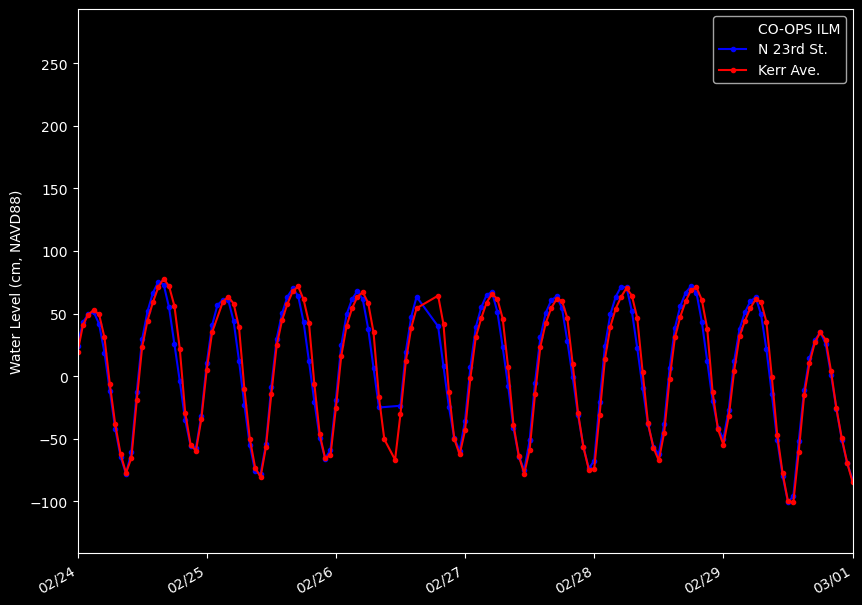

In [20]:
fig, axs = plt.subplots(figsize = (10, 8))
axs.plot(df_coops['Date Time'], df_coops['Water Level']*100, 'k.-', markersize = 2, label = 'CO-OPS ILM')
axs.plot(df_n23['Time (ET)'], df_n23['Water Level (cm)'], 'b.-', label = 'N 23rd St.')
axs.plot(df_kerr['Time (ET)'], df_kerr['Water Level (cm)'], 'r.-', label = 'Kerr Ave.')

axs.set_ylabel('Water Level (cm, NAVD88)')
axs.legend()

# xtick dates are poorly spaced
axs.xaxis.set_major_locator(ticker.MultipleLocator(1))

date_form = DateFormatter("%m/%d")
axs.xaxis.set_major_formatter(date_form)

axs.set_xlim([datetime.date(2024, 2, 24), datetime.date(2024, 3, 1)])

fig.autofmt_xdate()

### Find highs and lows
- Just for N23 for now; replicate (and change df name from tides to tides_N23 or whatever if using with Kerr/ILM)

In [21]:
# ChatGPT-generated peak-finder
# Step 1: Sort the dataframe by time to ensure chronological order
# done

# Step 2: Extract the water level data
water_levels = df_n23['Water Level (cm)'].values

# Step 3: Use scipy's find_peaks function to find peaks (high tides)
# We specify a minimum distance between peaks corresponding to roughly 6 hours (6 data points for hourly data)
peak_indices, _ = find_peaks(water_levels, distance=5)

# Step 4: Use scipy's find_peaks function to find troughs (low tides)
# To find troughs, we can invert the water level data and find peaks again
trough_indices, _ = find_peaks(-water_levels, distance=5)

# Step 5: Extract the times and water levels for high and low tides
high_tides = df_n23.iloc[peak_indices]
low_tides = df_n23.iloc[trough_indices]

# Step 6: Combine the high and low tides into a single dataframe for easier analysis
tides = pd.concat([high_tides.assign(Tide='High'), low_tides.assign(Tide='Low')])
tides = tides.sort_values(by='Time (ET)')

# Display the results
tides.head()

,Device_ID,Datetime Transmission,Sensor,Event,Unix Time,Distance (cm),Battery (V),Charge (%),Time (ET),Water Level (cm),Tide
362,e00fce686649823d18a012b5,2024-02-21 21:00:12,waterLevel_0000,waterLevel,1708567211,288.36667,4.00,85.91,2024-02-21 21:00:11-05:00,63.13333,High
373,e00fce686649823d18a012b5,2024-02-22 03:00:13,waterLevel_0000,waterLevel,1708588811,423.23749,3.94,83.03,2024-02-22 03:00:11-05:00,-71.73749,Low
384,e00fce686649823d18a012b5,2024-02-22 09:00:18,waterLevel_0000,waterLevel,1708610410,271.84723,3.92,82.38,2024-02-22 09:00:10-05:00,79.65277,High
397,e00fce686649823d18a012b5,2024-02-22 16:00:19,waterLevel_0000,waterLevel,1708635610,397.39584,4.05,82.21,2024-02-22 16:00:10-05:00,-45.89584,Low
406,e00fce686649823d18a012b5,2024-02-22 21:00:13,waterLevel_0000,waterLevel,1708653611,277.51807,4.01,82.05,2024-02-22 21:00:11-05:00,73.98193,High


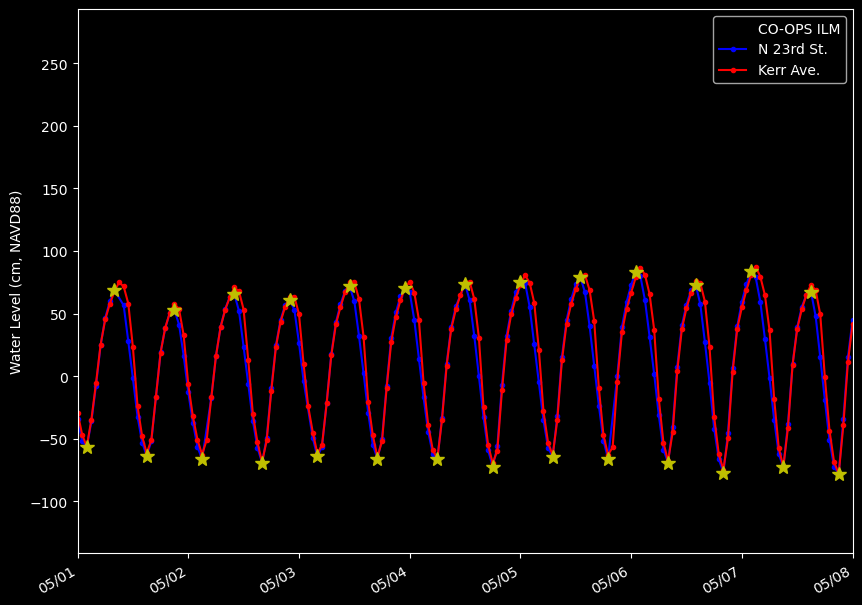

In [23]:
fig, axs = plt.subplots(figsize = (10, 8))

# Plot full t-s
axs.plot(df_coops['Date Time'], df_coops['Water Level']*100, 'k.-', markersize = 2, label = 'CO-OPS ILM')
axs.plot(df_n23['Time (ET)'], df_n23['Water Level (cm)'], 'b.-', label = 'N 23rd St.')
axs.plot(df_kerr['Time (ET)'], df_kerr['Water Level (cm)'], 'r.-', label = 'Kerr Ave.')

# Plot highs/lows with larger symbol
axs.plot(tides['Time (ET)'], tides['Water Level (cm)'], 'y*', markersize = 10)

# Labels, legend
axs.set_ylabel('Water Level (cm, NAVD88)')
axs.legend()

# xtick dates are poorly spaced
axs.xaxis.set_major_locator(ticker.MultipleLocator(1))

date_form = DateFormatter("%m/%d")
axs.xaxis.set_major_formatter(date_form)

axs.set_xlim([datetime.date(2024, 5, 1), datetime.date(2024, 5, 8)])

fig.autofmt_xdate()